Engineers and researchers in the automobile
industry have tried to design and build safer automobiles, but
traffic accidents are unavoidable. Patterns involved in
dangerous crashes could be detected if we develop a
prediction model that automatically classifies the type of
injury severity of various traffic accidents. These behavioral
and roadway patterns are useful in the development of traffic
safety control policy. 

Road accidents are never a happy issue to discuss. It not only has severe consequences for those involved, it also affects the lives of many others like friends and family. With more vehicles on the road than ever before, its important to understand them in greater detail, and possibly ‘predict’ the locations and consequences of these accidents. Government agencies in the UK have been collecting data about the accidents that were reported since the year 2005. The data includes generic and specific details about the vehicles, driver, number of passengers and number of casualties.

With data available since 2005, one could develop a model to predict the accidents. We know that the data recorded in the database are for reported accidents, so we know for sure these accidents have ‘happened’. We use this data to predict the location of the accident, in terms of latitude and longitude, and also the number of expected casualties of the accidents.

## Research Goals

Identify and quantify associations (if any) between the number of causalities and other variables in the data set.

Explore whether it is possible to predict accident hot-spots based on the data.

### Predictive Analytics Problem? 

Can we predict the number of casualties of each accident? This is helpful for us to identify what features might be related to higher number of casualty in an accident and lower number of casualties in an accident?

We use xgboost (extreme gradient boosting) regressors for the model creation we have.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost
import math
from __future__ import division
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
from sklearn import cross_validation, tree, linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score

/Users/user/anaconda3/envs/7mw/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
%%time
df1 = pd.read_csv('/Users/user/Desktop/application/DHL/accidents_2005_to_2007.csv',low_memory=False)
df2 = pd.read_csv('/Users/user/Desktop/application/DHL/accidents_2009_to_2011.csv',low_memory=False)
df3 = pd.read_csv('/Users/user/Desktop/application/DHL/accidents_2012_to_2014.csv',low_memory=False)

# check if the three datasets have same column headers
df1.columns.difference(df2.columns).difference(df3.columns)

# combine three datasets into one
df = pd.concat([df1, df2, df3],ignore_index=True)

print('Number of rows and collumns',df1.shape,df2.shape,df3.shape,df.shape)

Number of rows and collumns (570011, 33) (469442, 33) (464697, 33) (1504150, 33)
CPU times: user 12.4 s, sys: 2.21 s, total: 14.7 s
Wall time: 15.2 s


In [3]:
df.columns

Index(['Accident_Index', 'Location_Easting_OSGR', 'Location_Northing_OSGR',
       'Longitude', 'Latitude', 'Police_Force', 'Accident_Severity',
       'Number_of_Vehicles', 'Number_of_Casualties', 'Date', 'Day_of_Week',
       'Time', 'Local_Authority_(District)', 'Local_Authority_(Highway)',
       '1st_Road_Class', '1st_Road_Number', 'Road_Type', 'Speed_limit',
       'Junction_Detail', 'Junction_Control', '2nd_Road_Class',
       '2nd_Road_Number', 'Pedestrian_Crossing-Human_Control',
       'Pedestrian_Crossing-Physical_Facilities', 'Light_Conditions',
       'Weather_Conditions', 'Road_Surface_Conditions',
       'Special_Conditions_at_Site', 'Carriageway_Hazards',
       'Urban_or_Rural_Area', 'Did_Police_Officer_Attend_Scene_of_Accident',
       'LSOA_of_Accident_Location', 'Year'],
      dtype='object')

# Add additional features to be used in prediction

In [4]:
df['Date'] = pd.to_datetime(df['Date'],dayfirst=True)

In [5]:
def to_hour(time):
    try:
        hour = datetime.strptime(str(time), '%H:%M')
        return int(datetime.strftime(hour, '%H'))
    except Exception:
        return 0

In [6]:
# Extract month, day of month, day of year from Date Column
df['month'] = df['Date'].apply(lambda x: x.month)
df['day_of_month'] = df['Date'].apply(lambda x: x.day)
df['day_of_year'] = df['Date'].apply(lambda x: x.dayofyear)
df['hour'] = df['Time'].apply(to_hour)

In [7]:
del df['Junction_Detail']
df = df.dropna(how='any',axis=0) 

# Discretize Categorical Data

In [8]:
cat_columns = ['Local_Authority_(Highway)',
'Road_Type',
'Junction_Control',
'Pedestrian_Crossing-Human_Control',
'Pedestrian_Crossing-Physical_Facilities',
'Light_Conditions', 
'Weather_Conditions', 
'Road_Surface_Conditions',
'Did_Police_Officer_Attend_Scene_of_Accident',
'Urban_or_Rural_Area',
'Accident_Severity',
'Day_of_Week',
'1st_Road_Class',
'2nd_Road_Class']

prefix_cols = ['Local_Authority_(Highway)',
'Road_Type',
'Junction_Control',
'Pedestrian_Crossing-Human_Control',
'Pedestrian_Crossing-Physical_Facilities',
'Light_Conditions', 
'Weather_Conditions', 
'Road_Surface_Conditions',
'Did_Police_Officer_Attend_Scene_of_Accident',
'Urban_or_Rural_Area',
'Accident_Severity',
'Day_of_Week',
'1st_Road_Class',
'2nd_Road_Class']

In [9]:
df = pd.get_dummies(df, columns=cat_columns, prefix=cat_columns)

In [10]:
target = 'Number_of_Casualties'
features = [col for col in df.columns if col not in ['Accident_Index','Number_of_Casualties', 'Date', 
                                                     'Time','Special_Conditions_at_Site','Carriageway_Hazards',
                                                     'Local_Authority_(Highway)','LSOA_of_Accident_Location',
                                                     'Local_Authority_(Highway)']]

In [63]:
features

['Location_Easting_OSGR',
 'Location_Northing_OSGR',
 'Longitude',
 'Latitude',
 'Police_Force',
 'Number_of_Vehicles',
 'Local_Authority_(District)',
 '1st_Road_Number',
 'Speed_limit',
 '2nd_Road_Number',
 'Year',
 'month',
 'day_of_month',
 'day_of_year',
 'hour',
 'Local_Authority_(Highway)_E06000001',
 'Local_Authority_(Highway)_E06000002',
 'Local_Authority_(Highway)_E06000003',
 'Local_Authority_(Highway)_E06000004',
 'Local_Authority_(Highway)_E06000005',
 'Local_Authority_(Highway)_E06000006',
 'Local_Authority_(Highway)_E06000007',
 'Local_Authority_(Highway)_E06000008',
 'Local_Authority_(Highway)_E06000009',
 'Local_Authority_(Highway)_E06000010',
 'Local_Authority_(Highway)_E06000011',
 'Local_Authority_(Highway)_E06000012',
 'Local_Authority_(Highway)_E06000013',
 'Local_Authority_(Highway)_E06000014',
 'Local_Authority_(Highway)_E06000015',
 'Local_Authority_(Highway)_E06000016',
 'Local_Authority_(Highway)_E06000017',
 'Local_Authority_(Highway)_E06000018',
 'Local_Auth

# Predicting Number of Casualties 

In [11]:
X = df[features].values
y = df[target].values

In [12]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y ,test_size=0.2)

### Simple linear regression model

In [13]:
regr = linear_model.LinearRegression()

In [14]:
regr.fit(X_train, y_train)
print(regr.predict(X_test))

[ 1.28804345  1.43143614  1.32055761 ...,  1.61030619  1.10897941
  1.41458937]


In [15]:
regr.score(X_test,y_test)

0.085311191642308049

In [16]:
# Calculate the Root Mean Squared Error
print("RMSE: %.2f"
      % math.sqrt(np.mean((regr.predict(X_test) - y_test) ** 2)))

RMSE: 0.72


## Using XGBoost Algorithm

In [17]:
# Let's try XGboost algorithm to see if we can get better results
xgb = xgboost.XGBRegressor(nthread=-1)

In [18]:
xgb.fit(X_train,y_train)
predictions = xgb.predict(X_test)
print(explained_variance_score(predictions,y_test))

-10.2938163527


In [19]:
# Calculate the Root Mean Squared Error
print("RMSE: %.2f"
      % math.sqrt(np.mean((xgb.predict(X_test) - y_test) ** 2)))

RMSE: 0.72


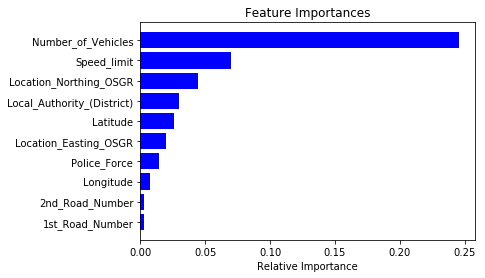

In [71]:
features = np.array(features)
importances = xgb.feature_importances_[:10]
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')
plt.show()

In [69]:
features

['Location_Easting_OSGR',
 'Location_Northing_OSGR',
 'Longitude',
 'Latitude',
 'Police_Force',
 'Number_of_Vehicles',
 'Local_Authority_(District)',
 '1st_Road_Number',
 'Speed_limit',
 '2nd_Road_Number',
 'Year',
 'month',
 'day_of_month',
 'day_of_year',
 'hour',
 'Local_Authority_(Highway)_E06000001',
 'Local_Authority_(Highway)_E06000002',
 'Local_Authority_(Highway)_E06000003',
 'Local_Authority_(Highway)_E06000004',
 'Local_Authority_(Highway)_E06000005',
 'Local_Authority_(Highway)_E06000006',
 'Local_Authority_(Highway)_E06000007',
 'Local_Authority_(Highway)_E06000008',
 'Local_Authority_(Highway)_E06000009',
 'Local_Authority_(Highway)_E06000010',
 'Local_Authority_(Highway)_E06000011',
 'Local_Authority_(Highway)_E06000012',
 'Local_Authority_(Highway)_E06000013',
 'Local_Authority_(Highway)_E06000014',
 'Local_Authority_(Highway)_E06000015',
 'Local_Authority_(Highway)_E06000016',
 'Local_Authority_(Highway)_E06000017',
 'Local_Authority_(Highway)_E06000018',
 'Local_Auth

# Predicting Latitude of the Accident

In [47]:
%%time
df1 = pd.read_csv('/Users/user/Desktop/application/DHL/accidents_2005_to_2007.csv',low_memory=False)
df2 = pd.read_csv('/Users/user/Desktop/application/DHL/accidents_2009_to_2011.csv',low_memory=False)
df3 = pd.read_csv('/Users/user/Desktop/application/DHL/accidents_2012_to_2014.csv',low_memory=False)

# check if the three datasets have same column headers
df1.columns.difference(df2.columns).difference(df3.columns)

# combine three datasets into one
df = pd.concat([df1, df2, df3],ignore_index=True)

print('Number of rows and collumns',df1.shape,df2.shape,df3.shape,df.shape)

Number of rows and collumns (570011, 33) (469442, 33) (464697, 33) (1504150, 33)
CPU times: user 11.4 s, sys: 2.46 s, total: 13.8 s
Wall time: 14.5 s


In [48]:
df['Date'] = pd.to_datetime(df['Date'],dayfirst=True)
df['month'] = df['Date'].apply(lambda x: x.month)
df['day_of_month'] = df['Date'].apply(lambda x: x.day)
df['day_of_year'] = df['Date'].apply(lambda x: x.dayofyear)
df['hour'] = df['Time'].apply(to_hour)

In [49]:
del df['Junction_Detail']
df = df.dropna(how='any',axis=0)

In [50]:
cat_columns = [
'Road_Type',
'Junction_Control',
'Pedestrian_Crossing-Human_Control',
'Pedestrian_Crossing-Physical_Facilities',
'Light_Conditions', 
'Weather_Conditions', 
'Road_Surface_Conditions',
'Did_Police_Officer_Attend_Scene_of_Accident',
'Urban_or_Rural_Area',
'Accident_Severity',
'Day_of_Week',
'1st_Road_Class',
'2nd_Road_Class']

prefix_cols = [
'Road_Type',
'Junction_Control',
'Pedestrian_Crossing-Human_Control',
'Pedestrian_Crossing-Physical_Facilities',
'Light_Conditions', 
'Weather_Conditions', 
'Road_Surface_Conditions',
'Did_Police_Officer_Attend_Scene_of_Accident',
'Urban_or_Rural_Area',
'Accident_Severity',
'Day_of_Week',
'1st_Road_Class',
'2nd_Road_Class']

In [51]:
df2 = pd.get_dummies(df, columns=cat_columns, prefix=cat_columns)

In [52]:
target2 = 'Latitude'
features2 = [col for col in df2.columns if col not in ['Accident_Index','Latitude', 'Longitude', 'Date', 
                                                     'Time','Special_Conditions_at_Site','Carriageway_Hazards',
                                                     'Local_Authority_(Highway)','LSOA_of_Accident_Location',
                                                     'Location_Easting_OSGR',
                                                     'Location_Northing_OSGR','Local_Authority_(District)']]

In [53]:
features2

['Police_Force',
 'Number_of_Vehicles',
 'Number_of_Casualties',
 '1st_Road_Number',
 'Speed_limit',
 '2nd_Road_Number',
 'Year',
 'month',
 'day_of_month',
 'day_of_year',
 'hour',
 'Road_Type_Dual carriageway',
 'Road_Type_One way street',
 'Road_Type_Roundabout',
 'Road_Type_Single carriageway',
 'Road_Type_Slip road',
 'Road_Type_Unknown',
 'Junction_Control_Authorised person',
 'Junction_Control_Automatic traffic signal',
 'Junction_Control_Giveway or uncontrolled',
 'Junction_Control_Stop Sign',
 'Pedestrian_Crossing-Human_Control_Control by other authorised person',
 'Pedestrian_Crossing-Human_Control_Control by school crossing patrol',
 'Pedestrian_Crossing-Human_Control_None within 50 metres',
 'Pedestrian_Crossing-Physical_Facilities_Central refuge',
 'Pedestrian_Crossing-Physical_Facilities_Footbridge or subway',
 'Pedestrian_Crossing-Physical_Facilities_No physical crossing within 50 meters',
 'Pedestrian_Crossing-Physical_Facilities_Pedestrian phase at traffic signal junct

In [54]:
X2 = df2[features2].values
y2 = df2[target2].values

In [55]:
X2_train, X2_test, y2_train, y2_test = cross_validation.train_test_split(X2, y2 ,test_size=0.2)

In [56]:
X2_train.shape, X2_test.shape, y2_train.shape, y2_test.shape

((676514, 76), (169129, 76), (676514,), (169129,))

In [57]:
regr2 = linear_model.LinearRegression()

In [58]:
regr2.fit(X2_train, y2_train)
print(regr2.predict(X2_test))

[ 52.98413617  52.88883869  51.13398787 ...,  52.77669684  51.04995694
  52.31625807]


In [59]:
regr2.score(X2_test,y2_test)

0.27675100900018268

In [60]:
# Calculate the Root Mean Squared Error
print("RMSE: %.2f"
      % math.sqrt(np.mean((regr2.predict(X2_test) - y2_test) ** 2)))

RMSE: 0.95


In [61]:
# Let's try XGboost algorithm to see if we can get better results
xgb2 = xgboost.XGBRegressor(nthread=-1)

In [92]:
# Calculate the Root Mean Squared Error
print("RMSE: %.2f"
      % math.sqrt(np.mean((xgb2.predict(X2_test) - y2_test) ** 2)))

RMSE: 0.15


In [62]:
xgb2.fit(X2_train,y2_train)
predictions2 = xgb2.predict(X2_test)
print(explained_variance_score(predictions2,y2_test))

0.980159491622


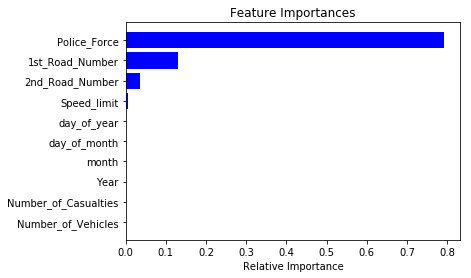

In [72]:
features2 = np.array(features2)
importances2 = xgb2.feature_importances_[:10]
indices2 = np.argsort(importances2)

plt.title('Feature Importances')
plt.barh(range(len(indices2)), importances2[indices2], color='b', align='center')
plt.yticks(range(len(indices2)), features2[indices2])
plt.xlabel('Relative Importance')
plt.show()

In [74]:
df2['Police_Force'].unique()

array([ 1, 48,  3,  4,  5,  6,  7, 10, 11, 12, 13, 14, 16, 17, 20, 21, 22,
       23, 30, 31, 32, 33, 34, 35, 36, 37, 40, 41, 42, 43, 44, 45, 46, 47,
       50, 52, 53, 54, 55, 60, 61, 62, 63, 91, 97])

# Predicting Longitude of the Accident

In [75]:
%%time
df1 = pd.read_csv('/Users/user/Desktop/application/DHL/accidents_2005_to_2007.csv',low_memory=False)
df2 = pd.read_csv('/Users/user/Desktop/application/DHL/accidents_2009_to_2011.csv',low_memory=False)
df3 = pd.read_csv('/Users/user/Desktop/application/DHL/accidents_2012_to_2014.csv',low_memory=False)

# check if the three datasets have same column headers
df1.columns.difference(df2.columns).difference(df3.columns)

# combine three datasets into one
df = pd.concat([df1, df2, df3],ignore_index=True)

print('Number of rows and collumns',df1.shape,df2.shape,df3.shape,df.shape)

Number of rows and collumns (570011, 33) (469442, 33) (464697, 33) (1504150, 33)
CPU times: user 12.2 s, sys: 2.84 s, total: 15 s
Wall time: 15.7 s


In [76]:
df['Date'] = pd.to_datetime(df['Date'],dayfirst=True)
df['month'] = df['Date'].apply(lambda x: x.month)
df['day_of_month'] = df['Date'].apply(lambda x: x.day)
df['day_of_year'] = df['Date'].apply(lambda x: x.dayofyear)
df['hour'] = df['Time'].apply(to_hour)

In [77]:
del df['Junction_Detail']
df = df.dropna(how='any',axis=0)

In [78]:
cat_columns = [
'Road_Type',
'Junction_Control',
'Pedestrian_Crossing-Human_Control',
'Pedestrian_Crossing-Physical_Facilities',
'Light_Conditions', 
'Weather_Conditions', 
'Road_Surface_Conditions',
'Did_Police_Officer_Attend_Scene_of_Accident',
'Urban_or_Rural_Area',
'Accident_Severity',
'Day_of_Week',
'1st_Road_Class',
'2nd_Road_Class']

prefix_cols = [
'Road_Type',
'Junction_Control',
'Pedestrian_Crossing-Human_Control',
'Pedestrian_Crossing-Physical_Facilities',
'Light_Conditions', 
'Weather_Conditions', 
'Road_Surface_Conditions',
'Did_Police_Officer_Attend_Scene_of_Accident',
'Urban_or_Rural_Area',
'Accident_Severity',
'Day_of_Week',
'1st_Road_Class',
'2nd_Road_Class']

In [79]:
df3 = pd.get_dummies(df, columns=cat_columns, prefix=cat_columns)

In [80]:
target3 = 'Longitude'
features3 = [col for col in df3.columns if col not in ['Accident_Index','Latitude', 'Longitude', 'Date', 
                                                     'Time','Special_Conditions_at_Site','Carriageway_Hazards',
                                                     'Local_Authority_(Highway)','LSOA_of_Accident_Location',
                                                     'Location_Easting_OSGR',
                                                     'Location_Northing_OSGR','Local_Authority_(District)']]

In [87]:
features3

['Police_Force',
 'Number_of_Vehicles',
 'Number_of_Casualties',
 '1st_Road_Number',
 'Speed_limit',
 '2nd_Road_Number',
 'Year',
 'month',
 'day_of_month',
 'day_of_year',
 'hour',
 'Road_Type_Dual carriageway',
 'Road_Type_One way street',
 'Road_Type_Roundabout',
 'Road_Type_Single carriageway',
 'Road_Type_Slip road',
 'Road_Type_Unknown',
 'Junction_Control_Authorised person',
 'Junction_Control_Automatic traffic signal',
 'Junction_Control_Giveway or uncontrolled',
 'Junction_Control_Stop Sign',
 'Pedestrian_Crossing-Human_Control_Control by other authorised person',
 'Pedestrian_Crossing-Human_Control_Control by school crossing patrol',
 'Pedestrian_Crossing-Human_Control_None within 50 metres',
 'Pedestrian_Crossing-Physical_Facilities_Central refuge',
 'Pedestrian_Crossing-Physical_Facilities_Footbridge or subway',
 'Pedestrian_Crossing-Physical_Facilities_No physical crossing within 50 meters',
 'Pedestrian_Crossing-Physical_Facilities_Pedestrian phase at traffic signal junct

In [81]:
X3 = df3[features3].values
y3 = df3[target3].values

In [82]:
X3_train, X3_test, y3_train, y3_test = cross_validation.train_test_split(X3, y3 ,test_size=0.2)

In [83]:
regr3 = linear_model.LinearRegression()

In [84]:
regr3.fit(X3_train, y3_train)
print(regr3.predict(X3_test))

[-0.90311451 -0.49555243 -1.44756069 ..., -1.0406618  -0.9086433
 -0.97634777]


In [85]:
regr3.score(X3_test,y3_test)

0.082052204945735285

In [86]:
# Calculate the Root Mean Squared Error
print("RMSE: %.2f"
      % math.sqrt(np.mean((regr3.predict(X3_test) - y3_test) ** 2)))

RMSE: 1.19


In [89]:
# Let's try XGboost algorithm to see if we can get better results
xgb3 = xgboost.XGBRegressor(nthread=-1)

In [90]:
xgb3.fit(X3_train,y3_train)
predictions3 = xgb3.predict(X2_test)
print(explained_variance_score(predictions3,y3_test))

-1.09480338209


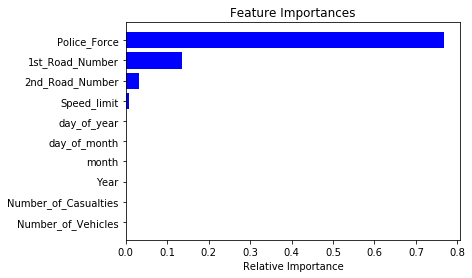

In [93]:
features3 = np.array(features3)
importances3 = xgb3.feature_importances_[:10]
indices3 = np.argsort(importances3)

plt.title('Feature Importances')
plt.barh(range(len(indices3)), importances3[indices3], color='b', align='center')
plt.yticks(range(len(indices3)), features3[indices2])
plt.xlabel('Relative Importance')
plt.show()

In [91]:
# Calculate the Root Mean Squared Error
print("RMSE: %.2f"
      % math.sqrt(np.mean((xgb3.predict(X3_test) - y3_test) ** 2)))

RMSE: 0.25
